In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pybaseball import statcast, playerid_lookup
from statsmodels.graphics.tsaplots import plot_acf
from pybaseball import playerid_lookup, statcast_pitcher
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm



/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def get_pitcher_statcast_data(first_name, last_name, start_year, end_year):
    try:
        player_info = playerid_lookup(last_name, first_name)
        player_id = player_info['key_mlbam'].values[0]
        print(f"Found MLBAM ID for {first_name} {last_name}: {player_id}")
    except:
        raise ValueError(f"Could not find player ID for {first_name} {last_name}")

    all_data = []
    for year in range(start_year, end_year + 1):
        print(f"Fetching data for {year}...")
        try:
            season_data = statcast_pitcher(f"{year}-03-01", f"{year}-11-15", player_id)
            if not season_data.empty:
                season_data['year'] = year
                all_data.append(season_data)
        except Exception as e:
            print(f"Failed to fetch data for {year}: {e}")

    if all_data:
        full_df = pd.concat(all_data, axis=0).reset_index(drop=True)
        print(f"Total pitches collected: {len(full_df)}")
    else:
        full_df = pd.DataFrame()
        print("No data collected.")
    
    return full_df

    
first_name = "Gerrit"
last_name = "Cole"
start_year = 2018
end_year = 2023

pitcher_data = get_pitcher_statcast_data(first_name, last_name, start_year, end_year)


Gathering player lookup table. This may take a moment.
Found MLBAM ID for Gerrit Cole: 543037
Fetching data for 2018...
Gathering Player Data
Fetching data for 2019...
Gathering Player Data
Fetching data for 2020...
Gathering Player Data
Fetching data for 2021...
Gathering Player Data
Fetching data for 2022...
Gathering Player Data
Fetching data for 2023...
Gathering Player Data
Total pitches collected: 19850


In [3]:
# Examine columns
for col in pitcher_data.columns:
    print(col) 

pitch_type
game_date
release_speed
release_pos_x
release_pos_z
player_name
batter
pitcher
events
description
spin_dir
spin_rate_deprecated
break_angle_deprecated
break_length_deprecated
zone
des
game_type
stand
p_throws
home_team
away_team
type
hit_location
bb_type
balls
strikes
game_year
pfx_x
pfx_z
plate_x
plate_z
on_3b
on_2b
on_1b
outs_when_up
inning
inning_topbot
hc_x
hc_y
tfs_deprecated
tfs_zulu_deprecated
umpire
sv_id
vx0
vy0
vz0
ax
ay
az
sz_top
sz_bot
hit_distance_sc
launch_speed
launch_angle
effective_speed
release_spin_rate
release_extension
game_pk
fielder_2
fielder_3
fielder_4
fielder_5
fielder_6
fielder_7
fielder_8
fielder_9
release_pos_y
estimated_ba_using_speedangle
estimated_woba_using_speedangle
woba_value
woba_denom
babip_value
iso_value
launch_speed_angle
at_bat_number
pitch_number
pitch_name
home_score
away_score
bat_score
fld_score
post_away_score
post_home_score
post_bat_score
post_fld_score
if_fielding_alignment
of_fielding_alignment
spin_axis
delta_home_win_exp
d

In [4]:

out_events = [
    'strikeout', 'field_out', 'grounded_into_double_play', 'double_play',
    'force_out', 'flyout', 'lineout', 'pop_out', 'sac_fly', 'sac_bunt', 'triple_play'
]
pitcher_data['is_out'] = pitcher_data['events'].isin(out_events).astype(int)
pitcher_data['in_zone'] = pitcher_data['zone'].between(1, 9).fillna(False).astype(int)

outs_per_game = pitcher_data.groupby('game_date')['is_out'].sum().reset_index()
outs_per_game['innings_pitched'] = outs_per_game['is_out'] / 3

zone_rate_per_game = pitcher_data.groupby('game_date')['in_zone'].mean().reset_index(name='zone_rate')


# Aggregating data by game to prepare our features for analysis. 
game_data = pitcher_data.groupby('game_date').agg({
    'pitch_type': np.size,
    'events': lambda x: np.sum(x == 'strikeout'),
    'release_speed': np.mean,
    'release_spin_rate': np.mean,
    'pitcher_days_since_prev_game': np.mean,
    'spin_axis': np.mean,
    'release_pos_x': np.mean,
    'pitch_number': np.mean,
    'release_extension': np.mean, 
    'api_break_x_arm': np.mean, 
    'arm_angle': np.mean,  


}).reset_index()

game_data = game_data.rename(columns={
    'pitch_type': 'total_pitches',
    'events': 'strikeouts',
    'release_speed': 'avg_velocity',
    'release_spin_rate': 'avg_spin_rate',
    'pitcher_days_since_prev_game': 'rest_days',
    'spin_axis': 'avg_spin_axis',
    'release_pos_x': 'avg_release_pos_x',
    'pitch_number': 'avg_pitch_number',
    'release_extension': 'avg_release_extension'
})

# Merge with innings pitched and zone rate
game_data = pd.merge(game_data, outs_per_game[['game_date', 'innings_pitched']], on='game_date', how='left')
game_data = pd.merge(game_data, zone_rate_per_game, on='game_date', how='left')
game_data = game_data.sort_values('game_date').reset_index(drop=True)


/var/folders/g8/kwj12nxd4gz7y8146hsnf5940000gn/T/ipykernel_65240/229078437.py:15: FutureWarning: The provided callable <function mean at 0x119eae9d0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  game_data = pitcher_data.groupby('game_date').agg({


In [5]:
# Defining time series weekly and defining strike outs per 9 innings

def get_season_base(year):
    return pd.to_datetime(f'{year}-04-01').isocalendar().week

game_data['game_date'] = pd.to_datetime(game_data['game_date'])
game_data['year'] = game_data['game_date'].dt.year
game_data['week_of_year'] = game_data['game_date'].dt.isocalendar().week
game_data['season_base'] = game_data['year'].apply(get_season_base)
game_data['week_of_season'] = game_data['week_of_year'] - game_data['season_base'] + 1
season_map = {2018: 1, 2019: 2, 2021: 3, 2022: 4, 2023: 5}
game_data['season'] = game_data['year'].map(season_map)
game_data['weekx'] = game_data['season'] * 100 + game_data['week_of_season']

weekly_data = game_data.groupby('weekx').agg({
    'game_date': min,
    'total_pitches': np.sum,
    'strikeouts': np.sum,
    'innings_pitched': np.sum,
    'avg_velocity': np.mean,
    'avg_spin_rate': np.mean,
    'avg_spin_axis': np.mean,
    'zone_rate': np.mean,
    'rest_days': np.mean,
    'avg_release_pos_x': np.mean, 
    'avg_pitch_number': np.mean, 
    'avg_release_extension': np.mean,
    'api_break_x_arm': np.mean,
    'arm_angle': np.mean

}).reset_index()



weekly_data['K_per_9'] = (weekly_data['strikeouts'] / weekly_data['innings_pitched']) * 9
weekly_data = weekly_data.sort_values('game_date').reset_index(drop=True)
weekly_data['linear_week'] = np.arange(1, len(weekly_data) + 1)
print(weekly_data.head())
weekly_data.to_csv("weekly_data_for_r.csv", index=False)

print("CSV file 'weekly_data_for_r.csv' has been created.")


   weekx  game_date  total_pitches  strikeouts  innings_pitched  avg_velocity  \
0   97.0 2018-03-02             53           2         2.666667           NaN   
1   98.0 2018-03-07             27           4         3.666667           NaN   
2   99.0 2018-03-13             77           9         8.000000           NaN   
3  100.0 2018-03-23             38           6         3.333333           NaN   
4  101.0 2018-04-01            102          11         6.666667     90.602941   

   avg_spin_rate  avg_spin_axis  zone_rate  rest_days  avg_release_pos_x  \
0            NaN            NaN   0.000000        NaN                NaN   
1            NaN            NaN   0.000000        NaN                NaN   
2            NaN            NaN   0.000000        NaN                NaN   
3            NaN            NaN   0.000000        NaN                NaN   
4    2391.494949     160.941176   0.539216        NaN          -2.398137   

   avg_pitch_number  avg_release_extension  api_break_x_

/var/folders/g8/kwj12nxd4gz7y8146hsnf5940000gn/T/ipykernel_65240/1447027674.py:15: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  weekly_data = game_data.groupby('weekx').agg({
/var/folders/g8/kwj12nxd4gz7y8146hsnf5940000gn/T/ipykernel_65240/1447027674.py:15: FutureWarning: The provided callable <function sum at 0x119eaa550> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  weekly_data = game_data.groupby('weekx').agg({
/var/folders/g8/kwj12nxd4gz7y8146hsnf5940000gn/T/ipykernel_65240/1447027674.py:15: FutureWarning: The provided callable <function mean at 0x119eae9d0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To

In [6]:

# Base line model - no exog features
y = weekly_data['K_per_9'].dropna().astype(float)

model_baseline = SARIMAX(
    endog=y,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


print("Baseline ARIMA(1,1,1) AIC:", model_baseline.aic)




Baseline ARIMA(1,1,1) AIC: 847.1903029013624


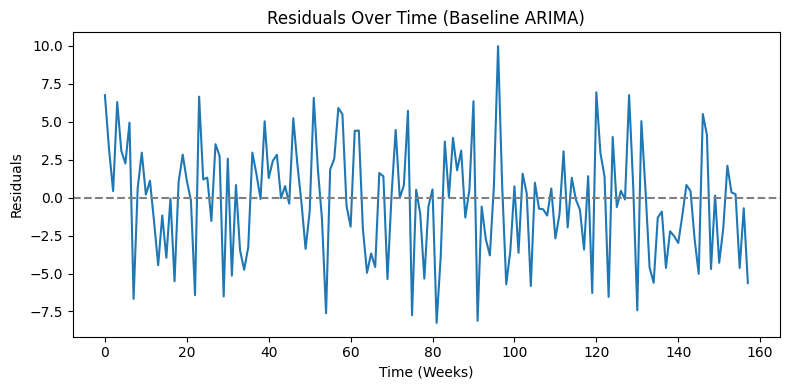

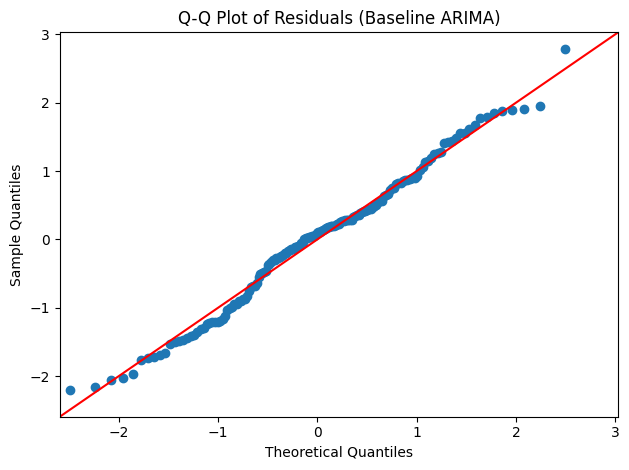

In [7]:
residuals = model_baseline.resid

plt.figure(figsize=(8, 4))
plt.plot(residuals)
plt.title("Residuals Over Time (Baseline ARIMA)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Residuals")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Baseline ARIMA)")
plt.tight_layout()
plt.show()


In [8]:
# ARIMAX With exog features

# Testing out some features we might think will help 
exog_vars = [
    'avg_velocity', 'avg_release_pos_x', 'avg_spin_rate', 'avg_pitch_number',
    'avg_release_extension', 'rest_days', 'zone_rate', 'arm_angle', 'api_break_x_arm'
]

X_exog = weekly_data[exog_vars].astype(float)
y = weekly_data['K_per_9'].astype(float)

aligned = pd.concat([y, X_exog], axis=1).dropna()
y_final = aligned['K_per_9']
X_final = aligned.drop(columns='K_per_9')

model_exog = SARIMAX(
    endog=y_final,
    exog=X_final,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


print(model_exog.summary())

                               SARIMAX Results                                
Dep. Variable:                K_per_9   No. Observations:                   79
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -195.474
Date:                Sun, 13 Apr 2025   AIC                            414.948
Time:                        21:50:55   BIC                            442.917
Sample:                             0   HQIC                           426.126
                                 - 79                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
avg_velocity             -0.6656      0.506     -1.315      0.189      -1.658       0.327
avg_release_pos_x        -2.3228      2.369     -0.980      0.327      -6.967       2.321
avg_spin

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
# Best features from above -> Zone rate, rest days, api_break_x_arm, avg_pitch number

exog_vars = [
    'zone_rate',  'rest_days', 'avg_pitch_number', 'api_break_x_arm'
]

X_exog = weekly_data[exog_vars].astype(float)
y = weekly_data['K_per_9'].astype(float)

aligned = pd.concat([y, X_exog], axis=1).dropna()
y_final = aligned['K_per_9']
X_final = aligned.drop(columns='K_per_9')

# Fit SARIMAX model
model_exog_important_features = SARIMAX(
    endog=y_final,
    exog=X_final,
    order=(3, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(model_exog_important_features.summary())

                               SARIMAX Results                                
Dep. Variable:                K_per_9   No. Observations:                  135
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -342.936
Date:                Sun, 13 Apr 2025   AIC                            703.871
Time:                        21:58:53   BIC                            729.748
Sample:                             0   HQIC                           714.386
                                - 135                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
zone_rate           -8.4931      5.937     -1.430      0.153     -20.130       3.144
rest_days            0.2746      0.317      0.866      0.387      -0.347       0.896
avg_pitch_number     3.2033 

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


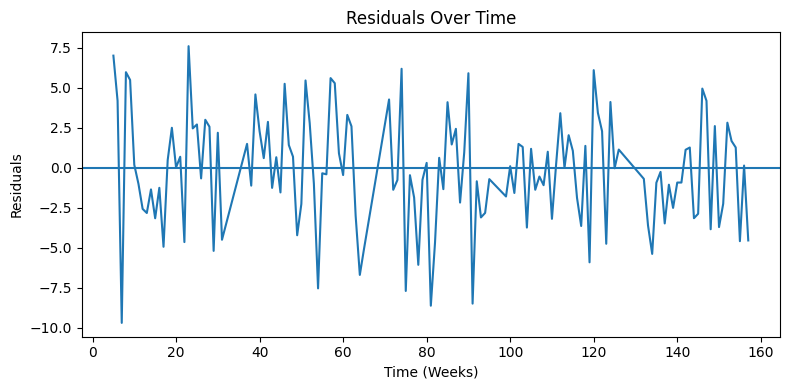

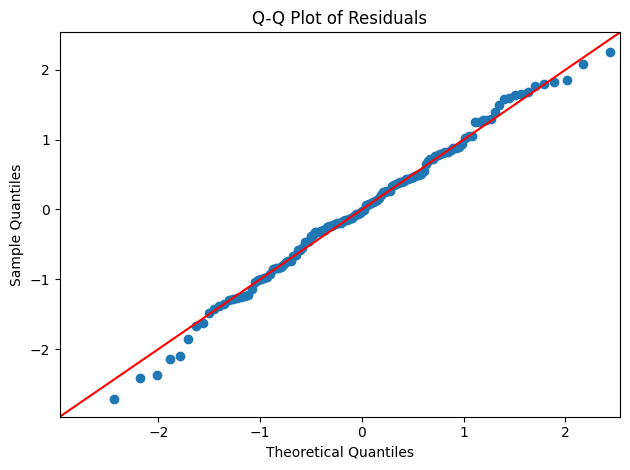

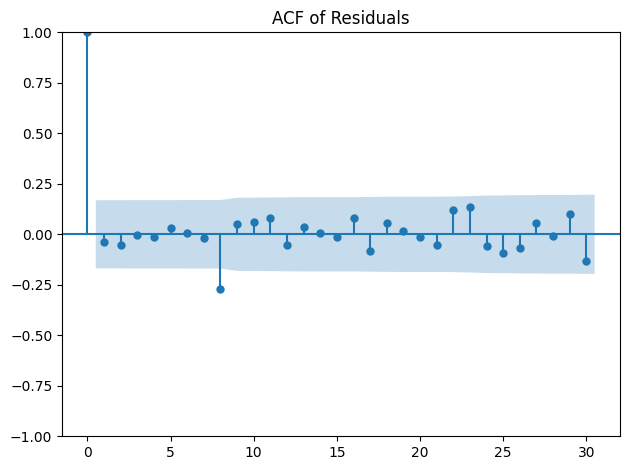

In [17]:
# Evaluation 
residuals = model_exog_important_features.resid

plt.figure(figsize=(8, 4))
plt.plot(residuals)
plt.axhline(0)
plt.title("Residuals Over Time")
plt.xlabel("Time (Weeks)")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

sm.graphics.tsa.plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.tight_layout()
plt.show()

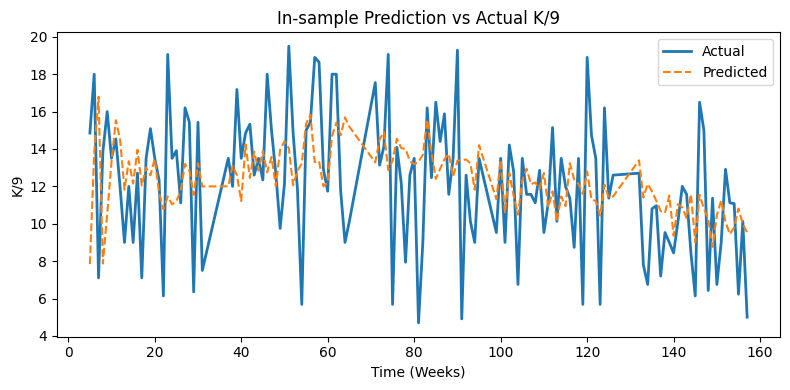

In [18]:
pred = model_exog_important_features.predict(start=0, end=len(y_final)-1, exog=X_final)

plt.figure(figsize=(8, 4))
plt.plot(y_final.index, y_final.values, label='Actual', linewidth=2)
plt.plot(y_final.index, pred, label='Predicted', linestyle='--')
plt.title("In-sample Prediction vs Actual K/9")
plt.xlabel("Time (Weeks)")
plt.ylabel("K/9")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
predicted_vals = model_exog_important_features.predict(start=0, end=len(y_final)-1, exog=X_final)

comparison_df = pd.DataFrame({
    'Actual_K_per_9': y_final.values,
    'Predicted_K_per_9': predicted_vals.values
})
print(comparison_df.head(30))

    Actual_K_per_9  Predicted_K_per_9
0        14.850000           7.841390
1        18.000000          13.811627
2         7.105263          16.793307
3        13.846154           7.871331
4        16.000000          10.509133
5        13.500000          13.311258
6        14.538462          15.539526
7        11.911765          14.478291
8         9.000000          11.823063
9        12.000000          13.350129
10        9.000000          12.151758
11       12.705882          13.955035
12        7.105263          12.038578
13       13.500000          13.013847
14       15.088235          12.586719
15       13.500000          13.476971
16       12.342857          11.652143
17        6.136364          10.776166
18       19.058824          11.458396
19       13.500000          11.036667
20       13.909091          11.200735
21       11.117647          11.779637
22       16.200000          13.198357
23       15.428571          12.861555
24        6.352941          11.542670
25       15.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Final features we think are best predictors
exog_vars = ['zone_rate', 'arm_angle', 'rest_days', 'avg_pitch_number', 'api_break_x_arm']
X_exog = weekly_data[exog_vars].astype(float)
y = weekly_data['K_per_9'].astype(float)
aligned = pd.concat([y, X_exog], axis=1).dropna()

split_index = int(len(aligned) * 0.8)
train_data = aligned.iloc[:split_index]
test_data = aligned.iloc[split_index:]

y_train = train_data['K_per_9']
X_train = train_data[exog_vars]

y_test = test_data['K_per_9']
X_test = test_data[exog_vars]

model_train = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(3, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

y_pred = model_train.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


RMSE: 3.104
MAE : 2.863
R²  : 0.079


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
